# Score matching, toy datasets, and Jax

[Score matching](https://yang-song.net/blog/2021/score/) is a technique to learn (the gradient of) data distributions, with applications in generative modelling and beyond. This post explores score matching on toy datasets. 

Score matching was introduced [in 2005](http://jmlr.org/papers/volume6/hyvarinen05a/old.pdf) but really came back into the spotlight [in 2019](https://arxiv.org/abs/1907.05600) when Song and Hermon used the technique to generate pictures that soon rivaled Generative Adversarial Networks. Score matching is also a [core component of diffusion models](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/). 


The goal is to approximate the data distribution $p_d$ with a model distribution $p_m$. Generally, fitting the parameters of $p_m$ is intractable in large dimensional spaces because of the partition function $Z_\theta$ (normalization term in $p_m$) that requires integrating over the entire dataset for every set of parameters during the training process. 



Methods that circumvent this difficulty include [Kernel density estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation) that make strong assumptions on the density estimator, or [Variational Autoencoders](https://lilianweng.github.io/posts/2018-08-12-vae/) that also make a normality assumption on the latent variables distribution.

Instead of learning the data distribution itself, we can learn its gradient. Score-matching does exactly this: it introduces a so-called "score function" $s_m$ (with a set parameters $\boldsymbol{\theta}$, typically the weights in a neural network) which models the gradient of (the log of) the data distribution $p_{d}$. 

$$
\mathbf{s}_{m}(\mathbf{x} ; \boldsymbol{\theta}) \triangleq \nabla_{\mathbf{x}} \log p_{m}(\mathbf{x} ; \boldsymbol{\theta}) = \nabla_{\mathbf{x}} \log \tilde p_{m}(\mathbf{x} ; \boldsymbol{\theta}) 
$$ 

where $\tilde p_m$ is the unnormalized density $\tilde p_m(\mathbf x, \mathbf \theta) = Z_\theta p_m (\mathbf x, \mathbf \theta)$.

Note that the presence of the log doesn't steer us away from the initial goal since

$$
\nabla_{\mathbf{x}} \log p(\mathbf{x}) = \frac1{p(\mathbf{x})}{\nabla_{\mathbf{x}} p(\mathbf{x})},
$$
i.e. the gradient of the log of the density is the gradient of the density, weighted by the inverse density.

Optimizing the score function is equivalent to minimizing the [Fisher divergence](https://en.wikipedia.org/wiki/Fisher_information_metric) between our model $s_m$ and the real score function $\mathbf{s}_{d}$ that we're trying to learn.

$$L(\boldsymbol{\theta}) \triangleq \frac{1}{2} \mathbb{E}_{p_{d}}\left[\left\|\mathbf{s}_{m}(\mathbf{x} ; \boldsymbol{\theta})-\mathbf{s}_{d}(\mathbf{x})\right\|_{2}^{2}\right],$$



[Hyvärinen (2005)](http://jmlr.org/papers/volume6/hyvarinen05a/old.pdf) showed that the Fisher divergence $L(\boldsymbol{\theta})$ is equal to

$$J(\boldsymbol{\theta}) \triangleq \mathbb{E}_{p_{d}}\left[\textcolor{green}{\operatorname{tr}\left(\nabla_{\mathbf{x}} \mathbf{s}_{m}(\mathbf{x} ; \boldsymbol{\theta})\right)}+\textcolor{red}{\frac{1}{2}\left\|\mathbf{s}_{m}(\mathbf{x} ; \boldsymbol{\theta})\right\|_{2}^{2}}\right],$$

up to an additive constant. In other words, for samples from the distribution $p_d$, the score function should have minimal <span style="color:green">gradient trace (i.e. be constant around sample coordinates)</span> and <span style="color:red">norm (i.e. be as small as possible)</span>. This loss function still not tractable in large dimensional spaces, but we can compute it in smaller dimensions.

 I'll be using the [Jax deep learning framework](https://github.com/google/jax), the latest cool kid on the neural networks block. Compared to PyTorch and TensorFlow, Jax is interesting because it has a functional spin and an interface very similar to Numpy. But let's get back to score matching.

In [6]:
!pip install --upgrade --quiet pip "jax[cpu]"

In [7]:
import numpy as np
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler

np.set_printoptions(precision=3)
np.random.seed(2022)

# Moon dataset
X, y = make_moons(n_samples=10000, noise=0.1, random_state=100)
X = StandardScaler().fit_transform(X).astype(np.float32)

In [8]:
import jax
from jax import numpy as jnp
from jax import random
from jax import jacfwd

seed = 8
rng = jax.random.PRNGKey(seed)

def dense_init(in_features, out_features, rng, 
               kernel_init=jax.nn.initializers.lecun_normal(),
               bias_init=jax.nn.initializers.zeros):
    k1, k2 = random.split(rng)
    kernel = kernel_init(k1, (in_features, out_features))
    bias = bias_init(k2, (out_features,))
    return kernel, bias

# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(sizes, key):
    keys = random.split(key, len(sizes))
    return [dense_init(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

def relu(x):
    return jnp.maximum(0, x)

def compute_score(params, x):
    """MLP for score computation, the input and output have the same 
    dimesion. """
    activations = x.T
    for w, b in params[:-1]:
        outputs = jnp.dot(w.T, activations) + b
        activations = relu(outputs)
    final_w, final_b = params[-1]
    return jnp.dot(final_w.T, activations.T) + final_b

@jax.jit
def batched_compute_score(params, x_batched):
    f = lambda x: compute_score(params, x)
    return jax.vmap(f)(x_batched)


def exact_matching_loss(params, inputs):
    """Compute the exact score matching loss function written in 
    the form presented by Hyvärinen (2005)."""
    f = lambda x: compute_score(params, x)
    score = f(inputs)
    Jacobian = jacfwd(f)(inputs)
    return jnp.trace(Jacobian) + jnp.linalg.norm(score)/2 + jnp.linalg.norm(score)

@jax.jit
def batched_loss_computation(params, x_batched):
    f = lambda x: exact_matching_loss(params, x)
    return jnp.mean(jax.vmap(f)(x_batched))

layers_sizes = [2, 64, 2]
params = init_network_params(layers_sizes, rng)

In [35]:
learning_rate = 0.01
w_test = jnp.ones([2,2]) #jnp.identity(2)
b_test = jnp.array([1., 1.])
params = (w_test, b_test)

x_test = jnp.array([[1., 2.], [3., 4.]])
print(compute_score(params, x_test[0]))
loss, params_grad = jax.value_and_grad(batched_loss_computation)(params, x_test)
kernel, bias = params
kernel -= learning_rate*params_grad[0]
bias -= learning_rate*params_grad[1]

learning_rate = 0.01
w_1_test = jnp.ones((2, 10))
b_1_test = jnp.ones((1, 10))
w_2_test = jnp.ones((10, 2))
b_2_test = jnp.ones((1, 2))
params = ((w_1_test, b_1_test), (w_2_test, b_2_test))

x_test = jnp.array([[1., 2.], [3., 4.], [5., 6.]])

print(f"Score: {compute_score(params, x_test[0])}")
print(f"Loss 1st sample: {exact_matching_loss(params, x_test[0])}")
print(f"Loss 2nd sample: {exact_matching_loss(params, x_test[1])}")
print(f"Batch loss: {batched_loss_computation(params, x_test)}")


[5. 5.]
Score: [[41. 41.]
 [41. 41.]]
Loss 1st sample: [143. 143.]
Loss 2nd sample: [263. 263.]
Batch loss: 263.0


In [30]:
params = dense_init(in_features=2, out_features=2, rng=rng)
learning_rate = 0.01

print(f"Initial loss: {batched_loss_computation(params, X)}")
for i, x in enumerate(jnp.array(X[:10])):
    if i % 1000 == 0:
        print(f"i={i}")
    loss, params_grad = jax.value_and_grad(exact_matching_loss)(params, x)
    params = [params[i] - learning_rate*params_grad[i] for i in range(2)]
print(f"Final loss: {batched_loss_computation(params, X)}")

Initial loss: 0.0
i=0
Final loss: nan


In [37]:
import numpy.random as npr
from jax.example_libraries.optimizers import adam

batch_size = 512
num_train = X.shape[0]
num_complete_batches, leftover = divmod(num_train, batch_size)
num_batches = num_complete_batches + bool(leftover)

random_num_gen = npr.RandomState(0)
def data_stream():
    perm = random_num_gen.permutation(num_train)
    for i in range(num_batches):
        batch_idx = perm[i * batch_size:(i + 1) * batch_size]
        yield X[batch_idx]
batches = data_stream()


@jax.jit
def update(params, x, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = jax.value_and_grad(batched_loss_computation)(params, x)
    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state, value

# Defining an optimizer in Jax
step_size = 1e-3
opt_init, opt_update, get_params = adam(step_size)
opt_state = opt_init(params)

num_epochs = 100

print(f"Initial loss: {batched_loss_computation(params, X):.3f}")
batch_loss = []
for epoch in range(num_epochs):
    batches = data_stream()
    for i, x_batch in enumerate(batches):
        params, opt_state, loss = update(params, x_batch, opt_state)
        batch_loss.append(batched_loss_computation(params, x_batch))
    loss = sum(batch_loss)/len(batch_loss)
    if epoch % 10 == 0:
        full_loss = batched_loss_computation(params, X)
        print(f"End of epoch {epoch}: loss={full_loss:.3f}")

Initial loss: 0.818
End of epoch 0: loss=-0.041
End of epoch 10: loss=-0.635
End of epoch 20: loss=-1.001
End of epoch 30: loss=-1.103
End of epoch 40: loss=-1.045
End of epoch 50: loss=-1.069
End of epoch 60: loss=-1.062
End of epoch 70: loss=-1.044
End of epoch 80: loss=-0.984
End of epoch 90: loss=-0.815


In [38]:
# from https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html#sphx-glr-auto-examples-classification-plot-classifier-comparison-py
plt.rcParams['figure.figsize'] = [13, 5]

original_datapoint = np.array([-1.7, -0.6])
X_sample = np.array([
    [-1.7, -0.6],
    [-1.3, 0.8],
    [-0.6, 1.5],
    [0.2, 0.6],
    [0.6, -0.1],
])

x_min, x_max, y_min, y_max, h = -2.5, 2.5, -2.5, 2.5, 0.1

xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
grid = np.c_[xx.ravel(), yy.ravel()]

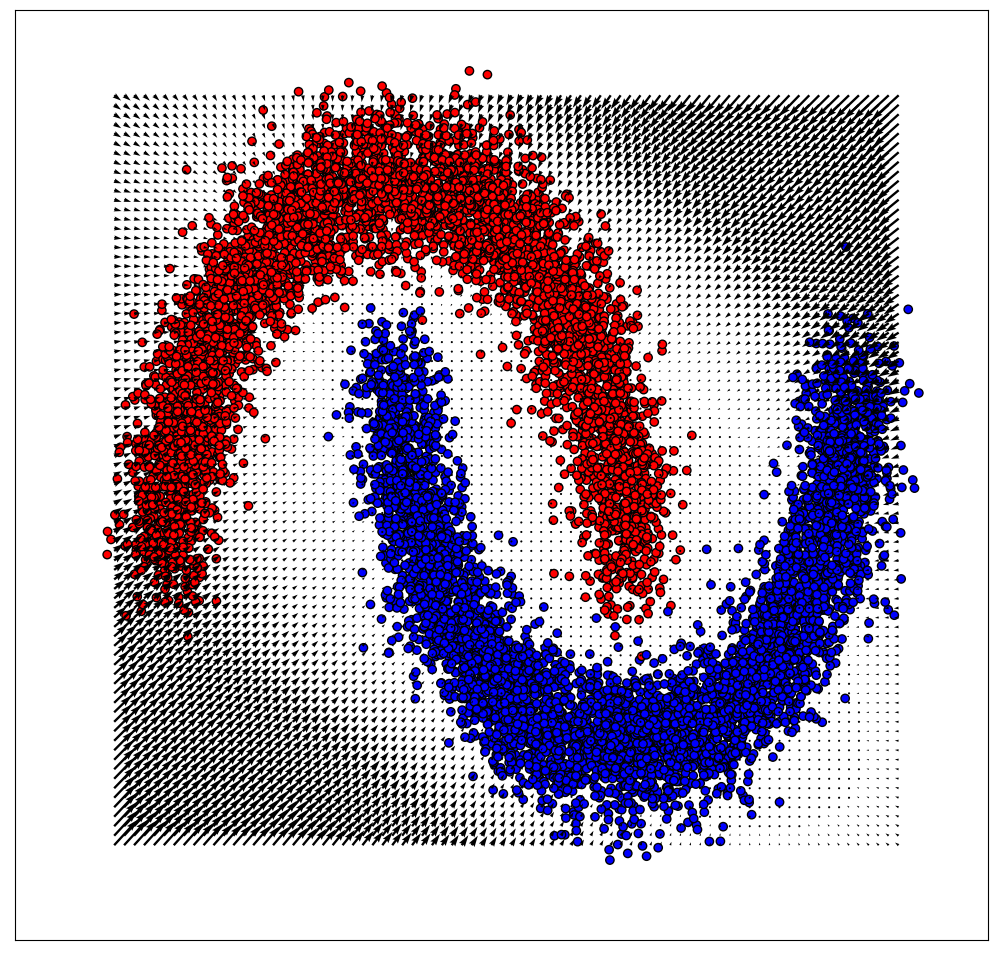

In [40]:
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import matplotlib.pyplot as plt

square_size = 2
x_grid, y_grid = np.meshgrid(np.arange(-square_size, square_size, 0.05), 
                     np.arange(-square_size, square_size, 0.05))
grid_points = np.c_[x_grid.ravel(), y_grid.ravel()]
density_grads = np.array(batched_compute_score(params, grid_points))

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

f, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright, edgecolors='k')
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())

plt.tight_layout()
f.set_figheight(10)
f.set_figwidth(10)

ax.quiver(x_grid, y_grid, density_grads[:, 0], density_grads[:, 1])
plt.show()

## On the ring dataset

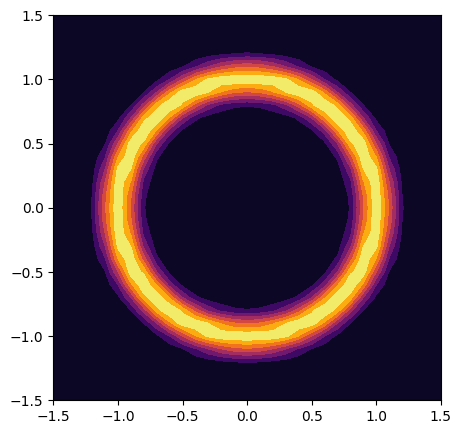

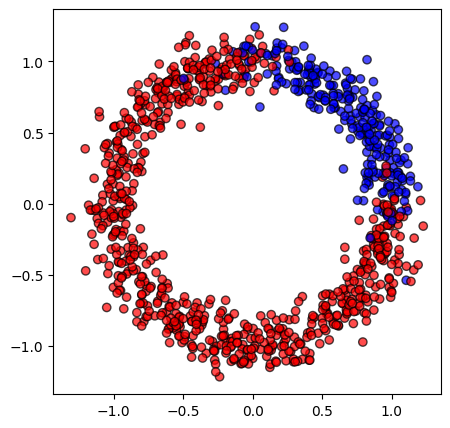

In [41]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

plt.rcParams["figure.figsize"] = (5, 5)

class RingDistribution:
    """Two-dimensional probability distribution centered around a ring, with radial 
    normal noise and uniform angular distribution.
    """
    def __init__(self, radius, std):
        self.mean = radius
        self.std = std

    def sample(self, n_samples, seed=None):
        """ Return an array of samples from the distribution."""
        np.random.seed(seed)
        r = np.random.normal(loc=self.mean, scale=self.std, size=n_samples)
        theta = np.random.uniform(low=-np.pi, high=np.pi, size=n_samples)

        x1 = r*np.cos(theta)
        x2 = r*np.sin(theta)
        x = np.array([x1, x2]).T

        y_prob = self.conditional_probability(theta)
        y = (np.random.uniform(size=y_prob.shape) < y_prob).astype(int)
        return x, y

    def pdf(self, x):
        """Probability density function."""
        r = np.sqrt((x**2).sum(axis=1))
        return norm.pdf(r, loc=self.mean, scale=self.std)

    def conditional_probability(self, theta, center=np.pi/4, dispersion=10):
        """Probability of y=1 given theta, p(y=1|theta). The conditional probability
        has a maximum at theta=pi/4 and follows a sigmoid distribution."""
        def sigmoid(x):
            return 1/(1+np.exp(-x))
        return sigmoid(dispersion*(center-np.abs(theta-center)))

    def plot_density(self):
        size = self.mean + 5*self.std
        step = 0.1
        x_min, x_max, y_min, y_max, h = -size, size+step, -size, size+step, step
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        grid = np.c_[xx.ravel(), yy.ravel()]
        
        probabilities = self.pdf(grid).reshape(xx.shape)

        fig, ax = plt.subplots()
        ax.contourf(xx, yy, probabilities, cmap="inferno", alpha=1.)
        return fig, ax

    def plot_samples(self):
        bright_colormap = ListedColormap(['#FF0000', '#0000FF'])
        x, y = self.sample(1000)
        fig, ax = plt.subplots()
        ax.scatter(x[:, 0], x[:, 1], c=y, cmap=bright_colormap, edgecolors='k', 
                                label=["Negative", "Positive"], alpha=0.7)
        return fig, ax

    def scores(self, x):
        """Gradient of the log of the PDF."""
        r = np.sqrt((x**2).sum(axis=1))
        scores = (x * (RADIUS/r - 1).reshape(-1, 1))
        return scores

RADIUS = 1
STD = 0.1
distribution = RingDistribution(radius=RADIUS, std=STD)
_, ax = distribution.plot_density()
distribution.plot_samples();
X, y = distribution.sample(n_samples=10000);

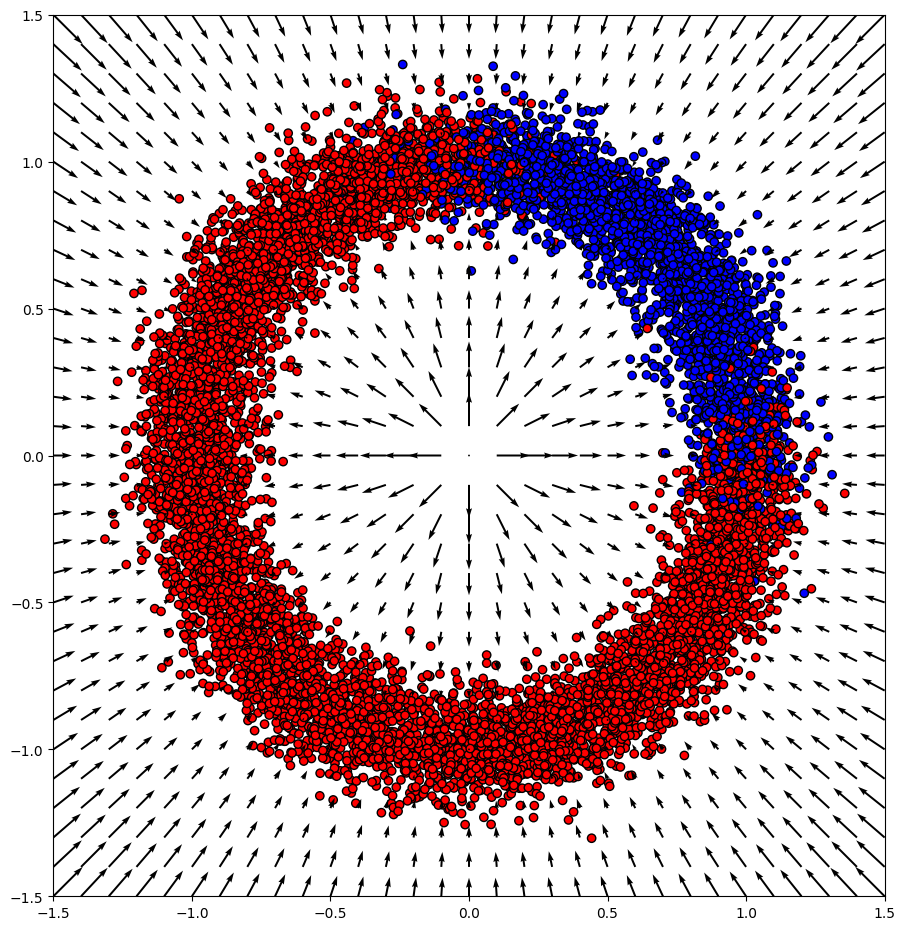

In [62]:
size = RADIUS + 5*STD
step = 0.1

x_grid, y_grid = np.meshgrid(
    np.arange(-size, size+step, step), 
    np.arange(-size, size+step, step)
)
grid_points = np.c_[x_grid.ravel(), y_grid.ravel()]

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

f, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright, edgecolors='k')
ax.set_xlim(x_grid.min(), x_grid.max())
ax.set_ylim(y_grid.min(), y_grid.max())

plt.tight_layout()
f.set_figheight(10)
f.set_figwidth(10)

scores = distribution.scores(grid_points)
scores[int(len(scores)/2)] = [0., 0.] # Center singularity
ax.quiver(x_grid, y_grid, scores[:, 0], scores[:, 1])


### Sliced score matching
[Sliced score matching](http://arxiv.org/abs/1905.07088) uses the [Hutchinson trick](http://blog.shakirm.com/2015/09/machine-learning-trick-of-the-day-3-hutchinsons-trick/) to compute the trace approximately with a stochastic sampling technique. The idea is to sample random vectors $\mathbf{v}$ with zero mean unit and unit variance and use the identity 
$$ \operatorname{tr}\left(A\right) =  \mathbb{E}_{p_\mathbf{v}} \left[ \mathbf{v}^T A \mathbf{v}\right].$$ 

For each datapoint $\mathbf{x}_i$ we draw $M$ random projection vectors $\mathbf{v}_{ij}$, such that the (tractable) estimated loss function reads:

$$J(\boldsymbol{\theta}) \simeq \frac1N \sum_{i=1}^N \left[\frac1M \sum_{j=1}^M\mathbf{v}_{ij}^T \left(\nabla_{\mathbf{x}} \mathbf{s}_{m}(\mathbf{x}_i ; \boldsymbol{\theta})\right) \mathbf{v}_{ij}+\frac{1}{2}\left\|\mathbf{s}_{m}(\mathbf{x}_i ; \boldsymbol{\theta})\right\|_{2}^{2}\right].$$